In [1]:
import os, sys
os.environ['ON_PY']="1"
os.chdir("/home/wlc/FJSP-DRL-MAML")
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录



(CVXPY) Apr 17 10:07:06 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 17 10:07:06 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML


In [2]:
instances = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5+mix': [array(11), array(11), array(11), array(11)],
 '20x5+mix': [array(11), array(11), array(11), array(11)],
 '15x10+mix': [array(11), array(11), array(11), array(11)],
 '20x10+mix': [array(11), array(11), array(11), array(11)]}

In [3]:
# 数学解



In [4]:
# # DAN 解

# args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",
#         "--test_model", "10x5x10+mix","20x5x10+mix", "15x10x10+mix", "20x10x10+mix"]
# configs = parser.parse_args(args=args)

# setup_seed(configs.seed_test)


# test_model = []

# for model_name in configs.test_model:
#     test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
# print(test_model)
# test_data = pack_data_from_config(configs.data_source, configs.test_data)

# print(os.getcwd())
# baseline_makespans = []
# for i in range(len(test_model)):
#     model = test_model[i]
#     data = test_data[i]
#     print("datta[1]: ",data[1])
#     print("-" * 25 + "Test Learned Model" + "-" * 25)
#     print(f"test data name: {data[1]}")
#     finetuning = True if model[1].startswith("maml") else False
#     print(f"Model name : {model[1]}")
#     result_5_times = []
#     for j in range(2):
#         test = Test(configs, data[0], model[0])
#         result = test.greedy_strategy(finetuning=finetuning)
#         # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        
#         result_5_times.append(result)
#     result_5_times = np.array(result_5_times)

#     save_result = np.mean(result_5_times, axis=0)
#     print("testing results:")
#     print(f"makespan(greedy): ", save_result[:, 0].mean())
#     baseline_makespans.append(save_result[:, 0].mean())
#     print(f"time: ", save_result[:, 1].mean())
#     # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
#     # print(f"Average fast_adapt time:", save_result[:, 3].mean())
#     print("="*100)

# print(baseline_makespans)




In [5]:
# MAML finetuning
# 获取finetuning的每个过程
class MAMLfinetuningClass:
    
    param_list_finetuning = []
    
    @staticmethod
    def MAML_finetuning_test(args):
        configs = parser.parse_args(args=args)
        print(configs.hidden_dim_actor, configs.hidden_dim_critic)
        test_model = []

        for model_name in configs.test_model:
            test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
        print(test_model)

        model = test_model[0]

        test_data = pack_data_from_config(configs.data_source, configs.test_data)
        makespans = []
        finetuning_makespans = []
        MAMLfinetuningClass.param_list_finetuning = []
        for data in test_data:
            print("datta[1]: ",data[1])
            print("-" * 25 + "Test Learned Model" + "-" * 25)
            print(f"test data name: {data[1]}")
            if model[1].startswith("maml"): finetuning = True
            print(f"Model name : {model[1]}")
            result_5_times = []
            test = Test(configs, data[0], model[0])
            result = test.finetuning(times=10)
            print(len(test.adapt_param_list))
            MAMLfinetuningClass.param_list_finetuning.append(test.adapt_param_list)

            finetuning_makespans.append(result)
            # result = test_greedy_strategy(data[0], model[0], config.seed_test)
            # print(result)
            for j in range(2):
                result = test.greedy_strategy()
                result_5_times.append(result)
            result_5_times = np.array(result_5_times)

            save_result = np.mean(result_5_times, axis=0)
            print("testing results:")
            print(f"makespan(greedy): ", save_result[:, 0].mean())
            makespans.append(save_result[:, 0].mean())
            print(f"time: ", save_result[:, 1].mean())
            # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
            # print(f"Average fast_adapt time:", save_result[:, 3].mean())
            print("="*100)

        return makespans, finetuning_makespans

def MAML_finetuning_test(args):
    return MAMLfinetuningClass.MAML_finetuning_test(args)


In [6]:
from sklearn.decomposition import PCA
from model.PPO import PPO_initialize
import torch
# 初始化 PPO 和参数列表
models = [f"{n_j}x{n_m}x0+mix" for n_j in range(5, 26, 5) for n_m in range(5, 26, 5) if n_j > n_m]
models.append("10x5+mix+SD2")
args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", "--test_model", *models]
configs = parser.parse_args(args=args)
test_model = [(f'./trained_network/{configs.model_source}/{model_name}.pth', model_name) for model_name in configs.test_model]

param_list = []

# 加载模型参数
for model_path, model_name in test_model:
    ppo = PPO_initialize(configs)
    # print(model_path)
    ppo.policy.load_state_dict(torch.load(model_path, map_location='cuda'))
    parameters = list(ppo.policy.actor.parameters())
    
    param_list.append(parameters)


64 64
[('./trained_network/SD2/maml+MAMLMK1713260928.pth', 'maml+MAMLMK1713260928')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLMK1713260928
10
testing results:
makespan(greedy):  443.6
time:  0.3033138871192932
[[ 1.9176645  -1.3535445 ]
 [ 2.081103   -0.98851174]
 [ 2.4606469  -0.6507097 ]
 [ 1.8294805  -1.7726173 ]
 [ 2.1328847  -0.2001305 ]
 [ 2.3607137   0.6344397 ]
 [ 1.8963408   0.0926678 ]
 [ 2.2807794   1.6434635 ]
 [ 2.0317087   2.6013994 ]
 [ 2.879808    1.1604369 ]
 [ 2.4228997  -1.3571997 ]
 [-2.0798554  -0.60819936]
 [-2.2954047  -0.44601583]
 [-2.4206536  -0.24011113]
 [-2.4709876  -0.14021234]
 [-2.5108385  -0.03738207]
 [-2.5073295   0.0767658 ]
 [-2.5336533   0.2349327 ]
 [-2.547147    0.3934904 ]
 [-2.5050635   0.46461856]
 [-2.4230967   0.49241927]]


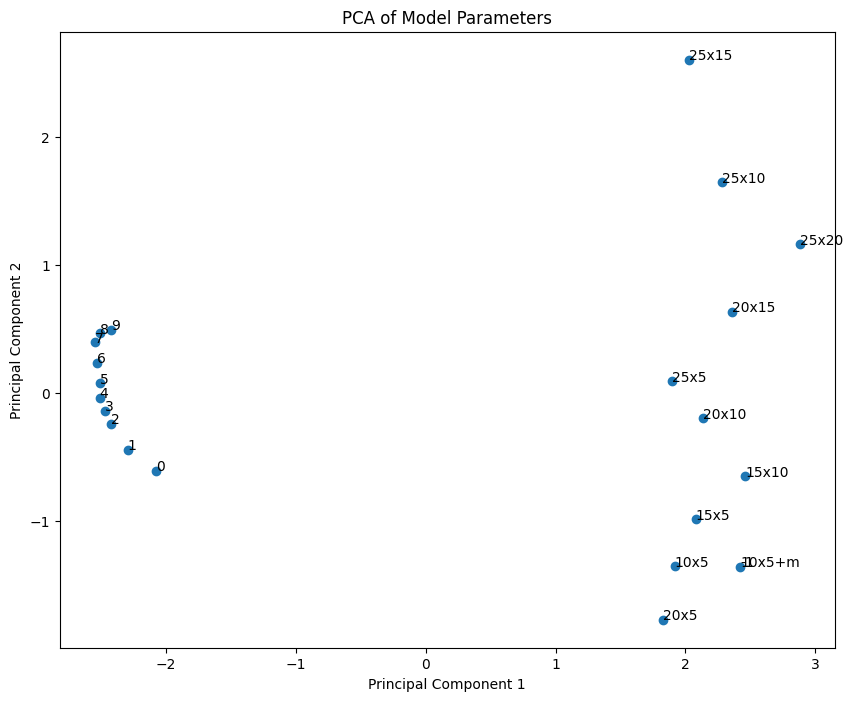

[443.6]
[[601.0, 599.0, 597.0, 588.0, 581.0, 519.0, 582.0, 455.0, 410.0, 490.0]]


In [7]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
model = "maml+MAMLMK1713260928"
args = ["--test_data", "10x5+mix", 
        # "20x5+mix", "15x10+mix", "20x10+mix", 
        # "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", model]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
# 创建参数矩阵
for finetuning_param in MAMLfinetuningClass.param_list_finetuning:
    collation_param = [*param_list, *finetuning_param]
    param_matrix = np.array([np.concatenate([p.data.cpu().numpy().flatten() for p in params]).flatten() for params in collation_param])

    # 使用 PCA 进行降维
    pca = PCA(n_components=2)
    params_reduced = pca.fit_transform(param_matrix)

    # 绘制结果，为每个点添加模型名称标签
    plt.figure(figsize=(10, 8))  # 可以调整大小以更好地适应所有标签
    plt.scatter(params_reduced[:, 0], params_reduced[:, 1], marker='o')

    print(params_reduced)
    # 为每个点添加文本标签
    end_i = 0
    for i, label in enumerate([name for _, name in test_model]):
        plt.annotate(label[:-6], (params_reduced[i, 0], params_reduced[i, 1]))
        end_i = i
    
    while end_i < len(params_reduced):
        plt.annotate(f"{end_i - len(test_model)}", (params_reduced[end_i, 0], params_reduced[end_i, 1]))
        end_i += 1

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Model Parameters')
    plt.show()
print(maml_makespans)
print(maml_finetuning_makespans)


In [8]:
# pretrain finetuning

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+EXP19maml1709218650"]

pre_train_makespans, pre_train_finetuning_makespans = MAML_finetuning_test(args)


print(plot_dict)

512 512
[('./trained_network/SD2/maml+EXP19maml1709218650.pth', 'maml+EXP19maml1709218650')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19maml1709218650
10


KeyboardInterrupt: 

In [ ]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2/test_random.pth')

args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--test_model", "test_random"]

random_makespans, random_finetuning_makespans = MAML_finetuning_test(args)



64 64
[('./trained_network/SD2/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random
50
testing results:
makespan(greedy):  628.5
time:  0.2991604208946228
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
50
testing results:
makespan(greedy):  1152.2
time:  0.6088766574859619
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
50
testing results:
makespan(greedy):  937.6
time:  0.9281322598457337
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random
50
testing results:
makespan(greedy):  1199.0
time:  1.2486530661582946


In [ ]:
from plot_imgs.plt_utils import plot_funetuning


In [ ]:
maml_finetuning_makespans = np.array(maml_finetuning_makespans[:,0])
pre_train_finetuning_makespans = np.array(pre_train_finetuning_makespans[:, 0])
random_finetuning_makespans = np.array(random_finetuning_makespans[:,0])
maml_finetuning_makespans.shape

TypeError: list indices must be integers or slices, not tuple

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'10x5+mix': [array([426.2, 426.2, 426.2, 426.2, 426.2]), array([455.8, 474.3, 464. , 460.4, 476.2]), array([491.4, 502.7, 491.3, 504. , 509.8]), array([635.8, 613. , 638.6, 665.2, 620.4])], '20x5+mix': [array([697.6, 697.6, 697.6, 697.6, 697.6]), array([755.7, 756.7, 734.8, 749.3, 752. ]), array([783.1, 789.2, 807.2, 777.5, 786.6]), array([1123.7, 1108. , 1157.7, 1116.9, 1148.8])], '15x10+mix': [array([585.4, 585.4, 585.4, 585.4, 585.4]), array([644. , 619.4, 629.7, 630.5, 653.1]), array([663.6, 676.3, 643.5, 662.9, 653.8]), array([957.4, 927.4, 934.3, 950.8, 979.1])], '20x10+mix': [array([631.1, 631.1, 631.1, 631.1, 631.1]), array([724. , 735.8, 733.2, 727.5, 737.2]), array([714.1, 721. , 732.9, 717.6, 709.7]), array([1201. , 1188.8, 1251.4, 1185.6, 1216.4])]}


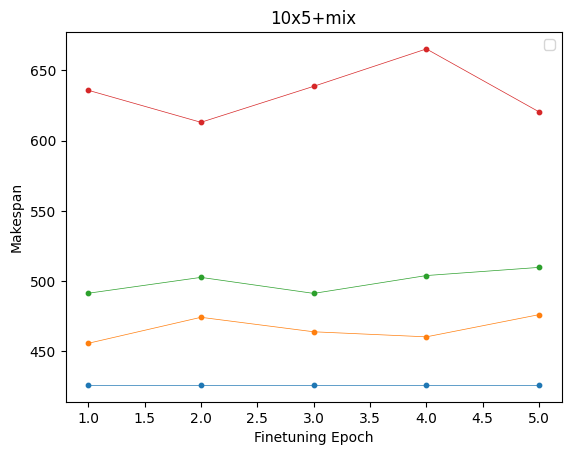

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


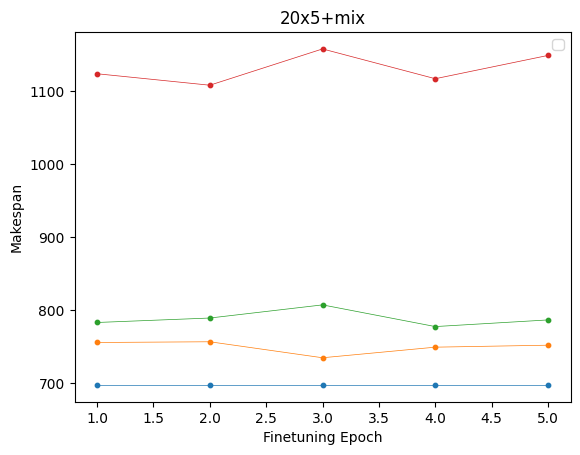

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


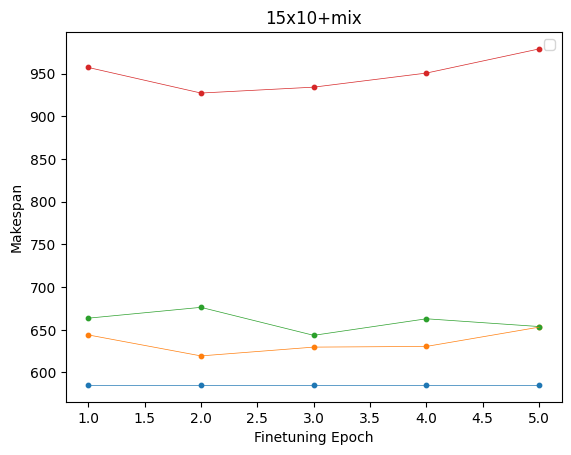

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


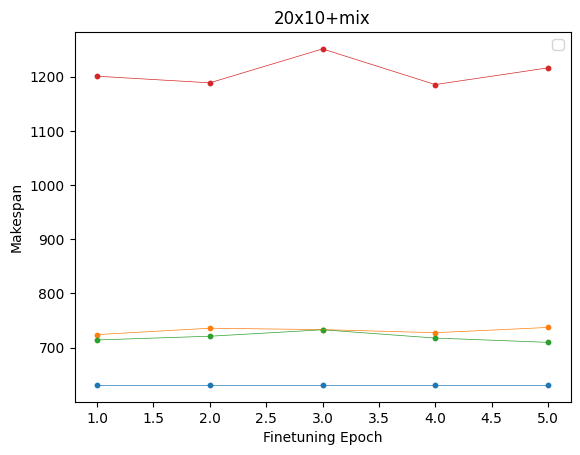

In [ ]:


for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(5, baseline_makespans[idx])
    plot_dict[key][1] = maml_finetuning_makespans[idx].mean(axis=0)
    plot_dict[key][2] = pre_train_finetuning_makespans[idx].mean(axis=0)
    plot_dict[key][3] = random_finetuning_makespans[idx].mean(axis=0)

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_funetuning(data, key)